In [12]:
import keras

m_c = keras.models.load_model('cifar/models/shadow_models/0.1/train/0.keras')

In [13]:
m_c.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 32, 32, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 16, 16, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 8, 8, 64)       │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_3           │ (None, 512)            │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,679,552 (6.41 MB)

 Trainable params: 559,850 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,119,702 (4.27 MB)

In [375]:
wb_test = load_model_params(50, all_y, base_path, 'test')

In [468]:
from common.whitebox_utils import get_dataset

base_path = "cifar/models/shadow_models"

ds = get_dataset(200, base_path, 'train')
ds_test = get_dataset(50, base_path, 'test)

conv_1 weights: KerasVariable shape=(3, 3, 3, 32)
3x3 filter für 3 channels, 32 stück
Die Reihenfolge *innerhalb* der filter ist wichtig, aber die Reihenfolge der filter selbst ist nicht relevant.

In [7]:
from keras import layers
from common.whitebox_utils import WeightsSplitter, BiasSplitter, ConvSplitter, transform_input_name

def get_wb_meta_clf(adv_inputs):
    inputs = []
    kernel_splitters = []
    bias_splitters = []
    
    phi_layers = []
    for i in range(len(adv_inputs)):
        for my_input in adv_inputs[i]:
            keras_input = keras.Input(shape=my_input.shape, name=transform_input_name(my_input.path, i))
            inputs.append(keras_input)
            if my_input.path.find("conv") >= 0 and my_input.path.find("kernel") >= 0:
                kernel_splitters.append(ConvSplitter(my_input.shape[3])(keras_input))
            elif my_input.path.find("bias") >= 0:
                bias_splitters.append(BiasSplitter(my_input.shape[0])(keras_input))
            else:
                kernel_splitters.append(WeightsSplitter(my_input.shape[1])(keras_input))
                
    phi_layers = []
    for kernels, biases in zip(kernel_splitters, bias_splitters):
        channel_outputs = []
        for w, b in zip(kernels, biases):
            flatten_w = layers.Flatten()(w)
            reshaped_b = layers.Reshape((1,))(b)
            concat = layers.concatenate([flatten_w, reshaped_b])
            phi = layers.Dense(20, activation="relu")(concat)
            channel_outputs.append(phi)
        my_phi = layers.Add()(channel_outputs)
        phi_layers.append(my_phi)
    
    x = layers.BatchNormalization()(layers.concatenate(phi_layers))
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(30, activation='relu')(x)
    
    #x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    
    return keras.Model(inputs=inputs, outputs=output)

In [15]:
adv_inputs_c = do_read_single_model_params(m_c)

In [16]:
meta_clf_c = get_wb_meta_clf(adv_inputs_c)

In [17]:
meta_clf.save("cifar/models/wb-cifar-meta-untrained.keras")

In [470]:
meta_clf = keras.models.load_model("wb-meta.keras")

In [500]:
meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [475]:
ds_test.save("cifar/data/white-box/test-data")

In [474]:
ds.save("cifar/data/white-box/train-data")

In [396]:
ds_test_batched = ds_test.batch(8)

In [480]:
ds_train = ds.shuffle(1800).batch(32, drop_remainder=True)

In [501]:
checkpoint_filepath = "cifar/models/manual_checkpoints/wb-meta/best.weights.h5"
history = meta_clf.fit(
    ds_train, epochs=70, 
    validation_data=ds_test_batched, 
    callbacks=[
        keras.callbacks.EarlyStopping('val_r2_score', patience=5),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_r2_score',
            mode='max',
            save_best_only=True)
    ])

Epoch 1/70


2024-04-09 15:41:17.937101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1056 of 1800


      1/Unknown 113s 113s/step - loss: 0.9204 - r2_score: -19.1211

2024-04-09 15:41:25.014600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


     56/Unknown 116s 72ms/step - loss: 0.7402 - r2_score: -13.2496

2024-04-09 15:41:29.128123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:42:20.441354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - loss: 0.7384 - r2_score: -13.1753 - val_loss: 0.5100 - val_r2_score: -4.8504
Epoch 2/70


2024-04-09 15:42:36.965536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 904 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.4918 - r2_score: -4.0982  

2024-04-09 15:42:44.436455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.4591 - r2_score: -4.0699

2024-04-09 15:42:50.318121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:42:55.445742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 286ms/step - loss: 0.4585 - r2_score: -4.0544 - val_loss: 0.3608 - val_r2_score: -1.9093
Epoch 3/70


2024-04-09 15:43:10.519485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 903 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2936 - r2_score: -1.4752

2024-04-09 15:43:18.133785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3186 - r2_score: -1.3891

2024-04-09 15:43:22.418415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:43:28.552643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 249ms/step - loss: 0.3183 - r2_score: -1.3837 - val_loss: 0.3432 - val_r2_score: -1.6615
Epoch 4/70


2024-04-09 15:43:42.363753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1151 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2595 - r2_score: -0.5268  

2024-04-09 15:43:49.267084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2612 - r2_score: -0.6641

2024-04-09 15:43:53.727695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:43:57.896722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - loss: 0.2610 - r2_score: -0.6602 - val_loss: 0.3121 - val_r2_score: -1.1608
Epoch 5/70


2024-04-09 15:44:12.314598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1165 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2422 - r2_score: -0.2724  

2024-04-09 15:44:17.211366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2196 - r2_score: -0.1056

2024-04-09 15:44:22.585716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:44:28.254354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - loss: 0.2194 - r2_score: -0.1036 - val_loss: 0.2558 - val_r2_score: -0.3762
Epoch 6/70


2024-04-09 15:44:43.719547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1037 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.2034 - r2_score: -0.2768  

2024-04-09 15:44:50.032383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1934 - r2_score: 0.1204

2024-04-09 15:44:54.475369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:44:59.588356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 276ms/step - loss: 0.1933 - r2_score: 0.1215 - val_loss: 0.2122 - val_r2_score: 0.0681
Epoch 7/70


2024-04-09 15:45:15.564493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1212 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.1757 - r2_score: 0.0556

2024-04-09 15:45:21.966570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1745 - r2_score: 0.2459

2024-04-09 15:45:26.370570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:45:32.256673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - loss: 0.1744 - r2_score: 0.2474 - val_loss: 0.1746 - val_r2_score: 0.3553
Epoch 8/70


2024-04-09 15:45:47.801464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1345 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 12:51 14s/step - loss: 0.2323 - r2_score: -0.1584

2024-04-09 15:45:51.586723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1709 - r2_score: 0.2998

2024-04-09 15:45:57.428293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:46:02.237592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - loss: 0.1708 - r2_score: 0.3014 - val_loss: 0.1636 - val_r2_score: 0.4209
Epoch 9/70


2024-04-09 15:46:17.156524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 956 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.1455 - r2_score: 0.3864  

2024-04-09 15:46:23.336369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1614 - r2_score: 0.3642

2024-04-09 15:46:28.021970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:46:34.082469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 265ms/step - loss: 0.1613 - r2_score: 0.3653 - val_loss: 0.1463 - val_r2_score: 0.4973
Epoch 10/70


2024-04-09 15:46:48.243254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1163 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1738 - r2_score: 0.2829

2024-04-09 15:46:55.481319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1540 - r2_score: 0.4389

2024-04-09 15:47:00.099055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:47:04.126892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - loss: 0.1539 - r2_score: 0.4395 - val_loss: 0.1647 - val_r2_score: 0.4436
Epoch 11/70


2024-04-09 15:47:15.444607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1108 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1385 - r2_score: 0.4369

2024-04-09 15:47:20.850029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1470 - r2_score: 0.4399

2024-04-09 15:47:25.121098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:47:31.313517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - loss: 0.1470 - r2_score: 0.4406 - val_loss: 0.1514 - val_r2_score: 0.4980
Epoch 12/70


2024-04-09 15:47:45.193032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1314 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 14:35 16s/step - loss: 0.1520 - r2_score: 0.4753

2024-04-09 15:47:50.762240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1422 - r2_score: 0.4773

2024-04-09 15:47:54.465697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:47:58.954863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - loss: 0.1422 - r2_score: 0.4776 - val_loss: 0.1525 - val_r2_score: 0.4963
Epoch 13/70


2024-04-09 15:48:09.994448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1103 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.1508 - r2_score: 0.5074 

2024-04-09 15:48:15.952424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1437 - r2_score: 0.4786

2024-04-09 15:48:20.233547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:48:24.856855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - loss: 0.1436 - r2_score: 0.4792 - val_loss: 0.1363 - val_r2_score: 0.5427
Epoch 14/70


2024-04-09 15:48:40.786838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1241 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1417 - r2_score: 0.4738  

2024-04-09 15:48:46.776209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1409 - r2_score: 0.4992

2024-04-09 15:48:50.970410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:48:55.847770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 173ms/step - loss: 0.1410 - r2_score: 0.4988 - val_loss: 0.1457 - val_r2_score: 0.5346
Epoch 15/70


2024-04-09 15:49:06.746095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1033 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1546 - r2_score: 0.5177

2024-04-09 15:49:13.176609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1434 - r2_score: 0.4961

2024-04-09 15:49:17.081339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:49:21.757210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - loss: 0.1433 - r2_score: 0.4966 - val_loss: 0.1379 - val_r2_score: 0.5498
Epoch 16/70


2024-04-09 15:49:37.297531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1329 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1343 - r2_score: 0.5596

2024-04-09 15:49:42.543330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1449 - r2_score: 0.4822

2024-04-09 15:49:46.778307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:49:51.164329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - loss: 0.1448 - r2_score: 0.4830 - val_loss: 0.1309 - val_r2_score: 0.5454
Epoch 17/70


2024-04-09 15:50:02.040676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1053 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.1529 - r2_score: 0.4044

2024-04-09 15:50:08.547276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1420 - r2_score: 0.4786

2024-04-09 15:50:12.543953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:50:17.875719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 282ms/step - loss: 0.1419 - r2_score: 0.4797 - val_loss: 0.1319 - val_r2_score: 0.5519
Epoch 18/70


2024-04-09 15:50:34.490549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1205 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 15:46 17s/step - loss: 0.1562 - r2_score: 0.5570

2024-04-09 15:50:41.243795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1400 - r2_score: 0.5112

2024-04-09 15:50:44.615886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:50:49.359058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - loss: 0.1399 - r2_score: 0.5116 - val_loss: 0.1372 - val_r2_score: 0.5504
Epoch 19/70


2024-04-09 15:51:00.245203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 996 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.1338 - r2_score: 0.5850

2024-04-09 15:51:06.896015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1361 - r2_score: 0.5074

2024-04-09 15:51:11.547914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:51:17.750115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 212ms/step - loss: 0.1361 - r2_score: 0.5081 - val_loss: 0.1307 - val_r2_score: 0.5162
Epoch 20/70


2024-04-09 15:51:28.861429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1178 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.1537 - r2_score: 0.4863

2024-04-09 15:51:35.708005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1370 - r2_score: 0.5049

2024-04-09 15:51:40.239139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:51:44.928598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step - loss: 0.1370 - r2_score: 0.5054 - val_loss: 0.1336 - val_r2_score: 0.5647
Epoch 21/70


2024-04-09 15:51:59.016353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 913 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 16:27 18s/step - loss: 0.1700 - r2_score: 0.1288

2024-04-09 15:52:06.579195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1409 - r2_score: 0.4927

2024-04-09 15:52:10.834062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:52:18.051288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.1408 - r2_score: 0.4938 - val_loss: 0.1279 - val_r2_score: 0.5559
Epoch 22/70


2024-04-09 15:52:29.030411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1127 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1275 - r2_score: 0.4922  

2024-04-09 15:52:36.379121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1379 - r2_score: 0.5059

2024-04-09 15:52:41.234308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:52:46.329417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - loss: 0.1378 - r2_score: 0.5064 - val_loss: 0.1397 - val_r2_score: 0.5542
Epoch 23/70


2024-04-09 15:52:57.693805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 793 of 1800
2024-04-09 15:53:07.703208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1678 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.1176 - r2_score: 0.5578

2024-04-09 15:53:10.258615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1329 - r2_score: 0.5293

2024-04-09 15:53:14.879978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:53:19.519277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - loss: 0.1330 - r2_score: 0.5297 - val_loss: 0.1351 - val_r2_score: 0.5624
Epoch 24/70


2024-04-09 15:53:30.404850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1078 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1367 - r2_score: 0.5598  

2024-04-09 15:53:36.670786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1305 - r2_score: 0.5499

2024-04-09 15:53:41.049406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:53:46.623110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - loss: 0.1305 - r2_score: 0.5501 - val_loss: 0.1261 - val_r2_score: 0.5626
Epoch 25/70


2024-04-09 15:53:58.576918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1015 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1026 - r2_score: 0.7052

2024-04-09 15:54:07.124651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1289 - r2_score: 0.5603

2024-04-09 15:54:11.459139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:54:16.116165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - loss: 0.1289 - r2_score: 0.5605 - val_loss: 0.1294 - val_r2_score: 0.5705
Epoch 26/70


2024-04-09 15:54:30.692862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1097 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.1331 - r2_score: 0.5388  

2024-04-09 15:54:36.361525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1339 - r2_score: 0.5297

2024-04-09 15:54:40.885739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:54:48.028964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - loss: 0.1339 - r2_score: 0.5302 - val_loss: 0.1267 - val_r2_score: 0.5464
Epoch 27/70


2024-04-09 15:54:59.443824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1195 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1420 - r2_score: 0.4489  

2024-04-09 15:55:06.378540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1345 - r2_score: 0.5299

2024-04-09 15:55:10.059322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:55:15.000928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - loss: 0.1344 - r2_score: 0.5305 - val_loss: 0.1320 - val_r2_score: 0.5676
Epoch 28/70


2024-04-09 15:55:25.810019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 961 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.1463 - r2_score: 0.5340

2024-04-09 15:55:32.545917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1334 - r2_score: 0.5404

2024-04-09 15:55:36.996936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:55:44.274664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - loss: 0.1333 - r2_score: 0.5410 - val_loss: 0.1262 - val_r2_score: 0.5399
Epoch 29/70


2024-04-09 15:55:55.467558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 965 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 18:55 21s/step - loss: 0.1211 - r2_score: 0.5522

2024-04-09 15:56:05.836172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1291 - r2_score: 0.5554

2024-04-09 15:56:10.119232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:56:15.493478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - loss: 0.1291 - r2_score: 0.5557 - val_loss: 0.1276 - val_r2_score: 0.5728
Epoch 30/70


2024-04-09 15:56:30.835386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1324 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 13:03 14s/step - loss: 0.1281 - r2_score: 0.6347

2024-04-09 15:56:34.874137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1363 - r2_score: 0.5304

2024-04-09 15:56:40.845033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:56:45.559119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 0.1362 - r2_score: 0.5311 - val_loss: 0.1240 - val_r2_score: 0.5542
Epoch 31/70


2024-04-09 15:56:56.473525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1149 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.1424 - r2_score: 0.3905  

2024-04-09 15:57:01.477237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1327 - r2_score: 0.4884

2024-04-09 15:57:05.796517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:57:10.821419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - loss: 0.1326 - r2_score: 0.4898 - val_loss: 0.1265 - val_r2_score: 0.5488
Epoch 32/70


2024-04-09 15:57:21.964115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 971 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.1293 - r2_score: 0.4485

2024-04-09 15:57:28.559060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1312 - r2_score: 0.5065

2024-04-09 15:57:34.536990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:57:39.238651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - loss: 0.1311 - r2_score: 0.5076 - val_loss: 0.1292 - val_r2_score: 0.5713
Epoch 33/70


2024-04-09 15:57:50.464196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 1142 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1477 - r2_score: 0.5203

2024-04-09 15:57:56.642824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1291 - r2_score: 0.5635

2024-04-09 15:58:01.607381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:58:06.486596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - loss: 0.1290 - r2_score: 0.5640 - val_loss: 0.1270 - val_r2_score: 0.5431
Epoch 34/70


2024-04-09 15:58:17.377090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:832: Filling up shuffle buffer (this may take a while): 969 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.1300 - r2_score: 0.5278  

2024-04-09 15:58:24.123612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1294 - r2_score: 0.5496

2024-04-09 15:58:28.942270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 15:58:35.528351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - loss: 0.1294 - r2_score: 0.5501 - val_loss: 0.1416 - val_r2_score: 0.5526


In [502]:
meta_clf.load_weights(checkpoint_filepath)

In [503]:
meta_clf.save("cifar/models/cifar-wb-meta-0.57-test-r2.keras")

In [506]:
# test output
sample = list(ds_test.shuffle(450).batch(8).as_numpy_iterator())
res = meta_clf(sample[0][0])
print(res)
true_y = sample[0][1]
print(true_y)

2024-04-09 16:00:44.927471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


tf.Tensor(
[[0.5439757 ]
 [0.3568683 ]
 [0.68535745]
 [0.6805703 ]
 [0.8974812 ]
 [0.6253698 ]
 [0.6300416 ]
 [0.74737465]], shape=(8, 1), dtype=float32)
[[0.1]
 [0.3]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.7]
 [0.8]]


In [346]:
import matplotlib.pyplot as plt

def plot_history(history, dist=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['r2_score'])
    plt.plot(history.history['val_r2_score'])
    plt.title(f'R2 Score ({"" if dist == None else dist*100}% old)')
    plt.ylabel('R2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()

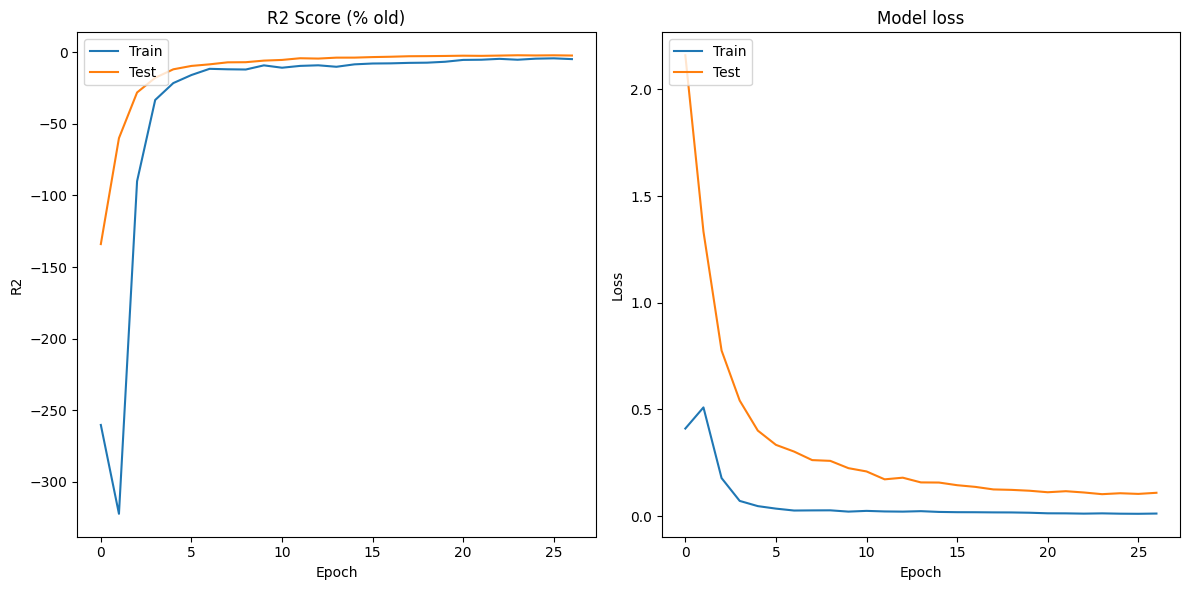

In [426]:
plot_history(history)

In [26]:
meta_clf_c = get_wb_meta_clf(adv_inputs_c)

In [27]:
meta_clf_c.load_weights("cifar/models/manual_checkpoints/wb-meta/best.weights.h5")

In [28]:
meta_clf_c.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [24]:
ds_test_cifar = tf.data.Dataset.load("cifar/data/white-box/test-data").batch(8)

In [29]:
meta_clf_c.evaluate(ds_test_cifar)

57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - loss: 0.2028 - r2_score: -7201462.5000


[0.129729762673378, 0.5728048086166382]

In [30]:
meta_clf_c.save_weights("cifar/models/wb_meta_0.57_test_r2.weights.h5")

# UTKFace Whitebox

In [1]:
import keras
from common.whitebox_utils import do_read_single_model_params

utk_base_path = "utkface/models/shadow_models"
m_utk = keras.models.load_model(f'{utk_base_path}/0.1/train/0.keras')
adv_inputs = do_read_single_model_params(m_utk)

2024-04-28 23:07:58.466305: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 23:07:58.474009: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 23:08:25.711069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from common.whitebox_utils import get_dataset

ds_utk = get_dataset(200, utk_base_path, 'train')
ds_test_utk = get_dataset(50, utk_base_path, 'test')

In [2]:
import tensorflow as tf

ds_utk = tf.data.Dataset.load("utkface/data/white-box/train-data")
ds_test_utk = tf.data.Dataset.load("utkface/data/white-box/test-data")

In [3]:
ds_utk_batched = ds_utk.shuffle(1800).batch(32, drop_remainder=True)
ds_test_utk_batched = ds_test_utk.batch(8)

In [8]:
meta_clf = get_wb_meta_clf(adv_inputs)

In [9]:
#meta_clf = keras.models.load_model("wb-meta.keras")
meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [11]:
round(0.333, 2)

0.33

In [10]:
checkpoint_filepath = "utkface/models/manual_checkpoints/wb-meta/best.weights.h5"

currentmax = 0.4
for i in range(50):
    meta_clf = get_wb_meta_clf(adv_inputs)
    meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])
    history = meta_clf.fit(
        ds_utk_batched, 
        epochs=70, 
        validation_data=ds_test_utk_batched, 
        callbacks=[
            keras.callbacks.EarlyStopping('val_r2_score', patience=5),
            keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_r2_score',
                mode='max',
                save_best_only=True)
        ])
    newmax = max(history.history['val_r2_score'])
    if newmax > currentmax:
        print(f"new max r2: {newmax}")
        currentmax = newmax
        meta_clf.load_weights("utkface/models/manual_checkpoints/wb-meta/best.weights.h5")
        meta_clf.save_weights(f"utkface/models/wb_adv_utk_{round(newmax, 2)}_test_r2.keras")

Epoch 1/70


2024-04-28 23:13:29.881601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 308 of 1800
2024-04-28 23:13:49.832787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 928 of 1800
2024-04-28 23:13:59.866512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1248 of 1800
2024-04-28 23:14:17.959463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - loss: 0.8119 - r2_score: -16.0972 - val_loss: 0.3750 - val_r2_score: -2.1614
Epoch 2/70


2024-04-28 23:15:42.641681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 276 of 1800
2024-04-28 23:15:52.646323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 890 of 1800
2024-04-28 23:16:02.657409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1485 of 1800
2024-04-28 23:16:09.149867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 430ms/step - loss: 0.4406 - r2_score: -3.6472 - val_loss: 0.4058 - val_r2_score: -2.6408
Epoch 3/70


2024-04-28 23:16:43.651067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 620 of 1800
2024-04-28 23:16:53.654065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1174 of 1800
2024-04-28 23:17:02.698326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 482ms/step - loss: 0.3322 - r2_score: -1.6078 - val_loss: 0.4484 - val_r2_score: -3.2161
Epoch 4/70


2024-04-28 23:17:40.005321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 605 of 1800
2024-04-28 23:17:57.569656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 575ms/step - loss: 0.2790 - r2_score: -0.8873 - val_loss: 0.3823 - val_r2_score: -2.0582
Epoch 5/70


2024-04-28 23:18:40.127326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 643 of 1800
2024-04-28 23:18:50.134639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1225 of 1800
2024-04-28 23:18:58.341119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


KeyboardInterrupt: 